<a href="https://colab.research.google.com/github/jiashenyue/ca-wui-pop-increase/blob/main/analysis_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Data Preparation**

- Shenyue Jia | [jiashenyue.info](https://www.jiashenyue.info/)

##**0. Overview**

- Prepare the data to estimate the drivers of population increase inside California's Wildland-Urban Interface (WUI), a high-risk zone of wildfire during the past decade (2010-2019)

###**Data dictionary**

- [ ] data dictionary

##**1. Data preparation**

###**1.1 Data inspection**

In [1]:
# import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# import libraries for machine learning
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import (ColumnTransformer, make_column_selector,
                             make_column_transformer)
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA

In [2]:
# inspect data
url = 'https://drive.google.com/file/d/13aOXzrxjMH7YH90vkxHyFQDm3OUGz_r7/view?usp=share_link'
url='https://drive.google.com/uc?id=' + url.split('/')[-2]
df = pd.read_csv(url)
df.head()

,geoid,county,trend,p_val,z_score,wui_class,owner_num,renter_num,annual_grow_rate,hai,...,whp_mean,whp_majority,whp_minority,whp_median,rps_mean,rps_median,rps_min,rps_max,rps_range,rent_own_ratio
0,6005000304,Amador County,increasing,0.001282,3.219938,Med_Dens_Interface,1289,390,0.80,141,...,3.660041,4,2,4,0.351582,0.374090,0.000000,0.793326,0.793326,0.303
1,6019005504,Fresno County,increasing,0.000347,3.577709,Low_Dens_Interface,957,148,3.65,124,...,1.000000,0,2,0,0.014541,0.010501,0.000000,0.071251,0.071251,0.155
2,6073010015,San Diego County,increasing,0.000677,3.398823,Med_Dens_Interface,765,207,3.98,96,...,2.349550,4,5,3,0.465186,0.272323,0.000000,1.221064,1.221064,0.271
3,6071008402,San Bernardino County,increasing,0.012266,2.504396,High_Dens_Interface,1910,411,0.44,147,...,0.000000,0,0,0,0.013819,0.000004,0.000000,0.598311,0.598311,0.215
4,6083000302,Santa Barbara County,decreasing,0.049098,-1.967740,High_Dens_Interface,415,1482,0.48,47,...,0.000000,0,0,0,0.000843,0.000320,0.000009,0.007597,0.007588,3.571


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1284 entries, 0 to 1283
Data columns (total 30 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   geoid                 1284 non-null   int64  
 1   county                1284 non-null   object 
 2   trend                 1284 non-null   object 
 3   p_val                 1284 non-null   float64
 4   z_score               1284 non-null   float64
 5   wui_class             1284 non-null   object 
 6   owner_num             1284 non-null   int64  
 7   renter_num            1284 non-null   int64  
 8   annual_grow_rate      1284 non-null   float64
 9   hai                   1284 non-null   int64  
 10  income_mortage_ratio  1284 non-null   float64
 11  diversity_index       1284 non-null   float64
 12  med_house_income      1284 non-null   int64  
 13  per_capita_income     1284 non-null   int64  
 14  med_home_value        1284 non-null   int64  
 15  annual_pop_change    

###**1.2 Target variable**

- **Option 1: use `z_score` column**
  - Coefficient of Mann-Kendall test, indicating how strong does the population change over the years relate to the time
- **Option 2: use `annual_grow_rate` column**
  - Annualized growing rate of population based on data from 2010 to 2019
- **Option 3: use `annual_pop_change` column**
  - Annualized number of population change based on data from 2010 to 2019
- **Option 4: use `percent_pop_change` column**
  - Annualized percentage of population change based on data from 2010 to 2019

- **We will try Option 1 (`z_score`)**
- **Only focus on rows with `z_score > 0` and `p_val < 0.05`**

In [4]:
# assignm target variable
target_val = 'percent_pop_change'

In [5]:
# # filter data to z_score > 0 and p_value < 0.05
# df_sig_increase = df[(df.z_score > 0) & (df.p_val < 0.05)]

In [6]:
# filter data to percent_pop_change > 0
df_sig_increase = df[(df.percent_pop_change > 0)]

In [7]:
# drop some target variable options
# drops = ['annual_grow_rate','annual_pop_change','percent_pop_change','p_val']
drops = ['z_score','annual_pop_change','annual_grow_rate','p_val']
df_sig_increase = df_sig_increase.drop(columns = drops)

In [8]:
# copy the original data and drop the first column for EDA
eda_df = df_sig_increase.copy()

In [9]:
print(f'Dataframe for EDA contains {eda_df.shape[0]} rows and {eda_df.shape[1]} columns')

Dataframe for EDA contains 1080 rows and 26 columns


###**1.3 Visualizing target variable**

In [10]:
col_pal = sns.color_palette('ch:1, r=1.45, l=.55, d=.395')
sns.color_palette('ch:1, r=1.45, l=.55, d=.395')

[(0.6671663710599731, 0.4639092574784279, 0.6833040561641264),
 (0.5944173789675091, 0.44686386017287955, 0.6879305278194555),
 (0.5144550874917323, 0.43625614508356136, 0.6777000916906704),
 (0.43233632850755416, 0.42992767975608875, 0.650398471074648),
 (0.3628802845356828, 0.4258241550971552, 0.6122790235874231),
 (0.2906687062148282, 0.42024281322903345, 0.553950436871317)]

In [11]:
## further confirm the outlier with a histogram
def box_plot(df, column_name,
             fs=(8,4), file_name='',
             tit_lab='', x_lab='', y_lab='', 
             fmt='',
             hza='center', rot=0):    
    # Variables
    feature = df[column_name]
    mean = feature.mean()
    median = feature.median()
    # Plot
    fig, ax = plt.subplots(nrows=1, figsize=fs, facecolor='w')
    sns.boxplot(data=df, x=column_name, width=.35, color=col_pal[4], ax=ax,
                medianprops={'color':'k', 'linewidth':1.5},
                whiskerprops={'color':'k', 'linewidth':1.5},
                boxprops={'facecolor':col_pal[4], 
                          'edgecolor':'k', 'linewidth':1.5},
                capprops={'color':'k', 'linewidth':1.5},
                flierprops={'marker':'o', 'markersize':8, 
                            'markerfacecolor':col_pal[4], 
                            'markeredgecolor':'k'}); 
    # Title and labels
    plt.title(tit_lab, fontsize = 16, weight='bold')
    plt.xlabel(x_lab, fontsize = 12, weight='bold')
    plt.ylabel('', fontsize = 12, weight='bold')
    # String format
    if fmt != '':
        ax.xaxis.set_major_formatter(fmt)
    # Ticks
    plt.xticks(fontsize=10, weight='bold')
    plt.yticks(fontsize=10, weight='bold')
    # Face 
    ax.set_facecolor('w')
    # Spines
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(2)
    # Vertical lines
    ax.axvline(mean, color = 'magenta', linewidth=2, 
               label=f'Mean = {mean:,.2f}')
    ax.axvline(median, ls='dotted', color = 'darkmagenta',  linewidth=2, 
               label=f'Median = {median:,.2f}')
    # Grid
    plt.grid(axis = 'x', lw=.5, c='k', alpha=.25)
    # Display
    ax.legend();
    plt.tight_layout()
    plt.show;

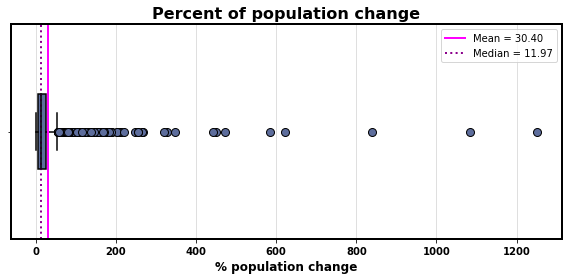

In [12]:
box_plot(eda_df, column_name = target_val,
             tit_lab='Percent of population change', 
             fs=(8,4),
         x_lab = '% population change')

In [13]:
# basic stats of target variable
eda_df[target_val].describe()

count    1080.000000
mean       30.403515
std        76.014389
min         0.056625
25%         5.619032
50%        11.971068
75%        24.853680
max      1250.000000
Name: percent_pop_change, dtype: float64

####**Findings**

- target variable column contains some outliers
- remove outliers with percent_pop_change >= 200%

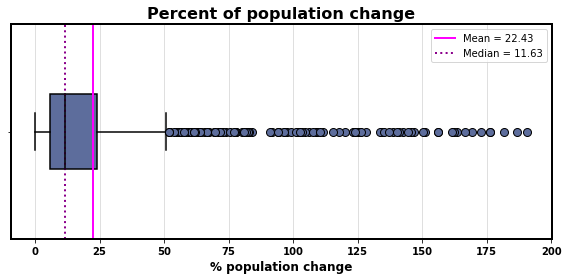

In [14]:
eda_df = eda_df[eda_df.percent_pop_change<200]
box_plot(eda_df, column_name = target_val,
             tit_lab='Percent of population change', 
             fs=(8,4),
         x_lab = '% population change')

In [15]:
# check max value
eda_df[target_val].describe()

count    1059.000000
mean       22.433942
std        31.114608
min         0.056625
25%         5.599416
50%        11.631944
75%        23.985019
max       190.757042
Name: percent_pop_change, dtype: float64

###**1.4 Check and fix data inconsistency**

- Check if there is any inconsistenty in categorical variables

In [16]:
# get index for selected cols
data_types = eda_df.dtypes
cols = data_types[data_types=='object'].index
cols

Index(['county', 'trend', 'wui_class'], dtype='object')

In [17]:
# loop over cols to print unique values
for col in cols:
 print(f"The unique values of the feature {col} are:\n")
 print(eda_df[col].value_counts())
 print("\n")

The unique values of the feature county are:

Los Angeles County        139
Riverside County          129
San Diego County           82
Contra Costa County        72
Alameda County             67
Orange County              50
Santa Clara County         48
San Bernardino County      42
Sacramento County          35
Ventura County             33
San Mateo County           32
Solano County              30
Placer County              27
Santa Barbara County       25
Sonoma County              22
Marin County               22
Monterey County            17
Kern County                15
Butte County               14
San Francisco County       14
Fresno County              14
San Luis Obispo County     14
El Dorado County           14
Shasta County              11
Santa Cruz County           9
Humboldt County             8
San Benito County           8
Napa County                 7
Merced County               7
San Joaquin County          6
Nevada County               4
Imperial County         

#### **Findings**

- There is no inconsistency in the categorical variables
- `county` and `trend` columns can be removed from the dataframe for modeling as they do not add values to analysis


###**1.5 Check and fix missing values**

- Check if missing values are present

In [18]:
# check if missing values are present in the data
eda_df.isna().sum()

geoid                   0
county                  0
trend                   0
wui_class               0
owner_num               0
renter_num              0
hai                     0
income_mortage_ratio    0
diversity_index         0
med_house_income        0
per_capita_income       0
med_home_value          0
percent_pop_change      0
whp_min                 0
whp_max                 0
whp_range               0
whp_mean                0
whp_majority            0
whp_minority            0
whp_median              0
rps_mean                0
rps_median              0
rps_min                 0
rps_max                 0
rps_range               0
rent_own_ratio          0
dtype: int64

In [19]:
# display the percentage of missing values by column
print(eda_df.isna().sum()/len(eda_df)*100)

geoid                   0.0
county                  0.0
trend                   0.0
wui_class               0.0
owner_num               0.0
renter_num              0.0
hai                     0.0
income_mortage_ratio    0.0
diversity_index         0.0
med_house_income        0.0
per_capita_income       0.0
med_home_value          0.0
percent_pop_change      0.0
whp_min                 0.0
whp_max                 0.0
whp_range               0.0
whp_mean                0.0
whp_majority            0.0
whp_minority            0.0
whp_median              0.0
rps_mean                0.0
rps_median              0.0
rps_min                 0.0
rps_max                 0.0
rps_range               0.0
rent_own_ratio          0.0
dtype: float64


- We can simply drop the row with a missing value in `rent_own_ratio`

####**Fix the `rent_own_ratio` column**

- Drop this row

In [20]:
# calculate the row index for rows with missing values
na_rows = eda_df[eda_df['rent_own_ratio'].isna()].index
na_rows

Int64Index([], dtype='int64')

In [21]:
# drop the row
eda_df = eda_df.drop(labels=na_rows, axis=0);

In [22]:
# display the percentage of missing values by column
print(eda_df.isna().sum()/len(eda_df)*100)

geoid                   0.0
county                  0.0
trend                   0.0
wui_class               0.0
owner_num               0.0
renter_num              0.0
hai                     0.0
income_mortage_ratio    0.0
diversity_index         0.0
med_house_income        0.0
per_capita_income       0.0
med_home_value          0.0
percent_pop_change      0.0
whp_min                 0.0
whp_max                 0.0
whp_range               0.0
whp_mean                0.0
whp_majority            0.0
whp_minority            0.0
whp_median              0.0
rps_mean                0.0
rps_median              0.0
rps_min                 0.0
rps_max                 0.0
rps_range               0.0
rent_own_ratio          0.0
dtype: float64


###**1.6 Check and fix duplicated values**

- Check if duplicated values are present

In [23]:
# identify duplicate rows
duplicateRows = eda_df[eda_df.duplicated()]
print(f'There are {len(duplicateRows)} duplicated rows in the dataframe')

There are 0 duplicated rows in the dataframe


##**2. EDA visualization**

###**2.1 Wildfire Hazard Potential (WHP) related variables**

In [24]:
# Create a function to create a KDE Plot
def kde_plot(df, column_name,
             fs=(8,4), file_name='',
             tit_lab='', x_lab='', y_lab='',
             fmt='',
             hza='center', rot=0):    
    # Variables
    feature = df[column_name]
    mean = feature.mean()
    median = feature.median()
    
    # PLot
    fig, ax = plt.subplots(nrows=1, figsize=fs, facecolor='w')
    sns.kdeplot(data=df, x=column_name, 
                color=col_pal[4], linewidth=1.25, fill=True)
    
    # Title and labels
    plt.title(tit_lab, fontsize = 16, weight='bold')
    plt.xlabel(x_lab, fontsize = 12, weight='bold')
    plt.ylabel('Density', fontsize = 12, weight='bold')
    # String format
    if fmt != '':
        ax.xaxis.set_major_formatter(fmt)
    # Ticks
    plt.xticks(fontsize=10, weight='bold')
    plt.yticks(fontsize=10, weight='bold')
    # Face 
    ax.set_facecolor('w')
    # Spines
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(2)
    # Vertical lines
    ax.axvline(mean, color = 'magenta', linewidth=2, 
               label=f'Mean = {mean:,.2f}')
    ax.axvline(median, ls='dotted', color = 'darkmagenta',  linewidth=2, 
               label=f'Median = {median:,.2f}')
    # Grid
    plt.grid(lw=.5, c='k', alpha=.25)
    # Display
    ax.legend();
    plt.tight_layout()
    plt.show;
    # Save an image of the plot
    if file_name != '':
        folder_file_name = image_folder_path + file_name
        plt.savefig(folder_file_name, format='png', 
                    facecolor='w', edgecolor='w')

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)


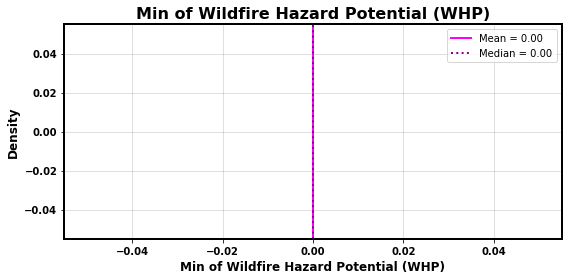

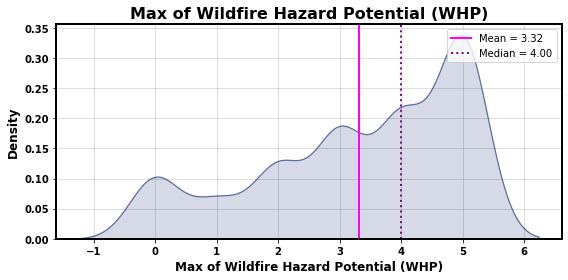

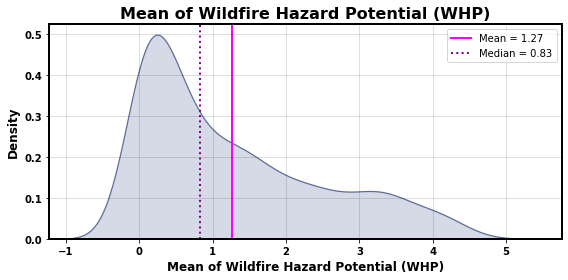

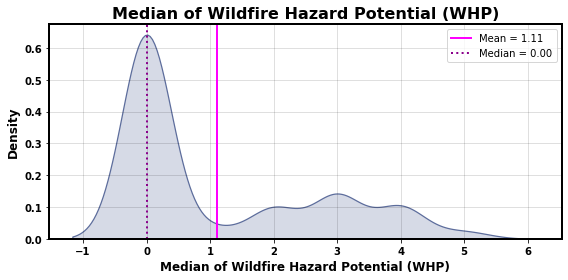

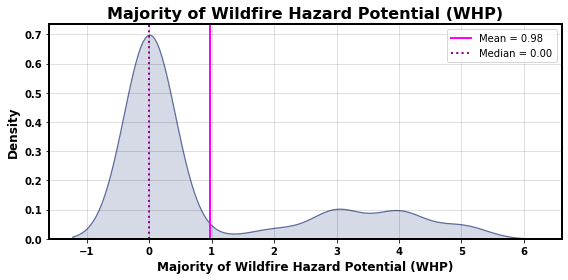

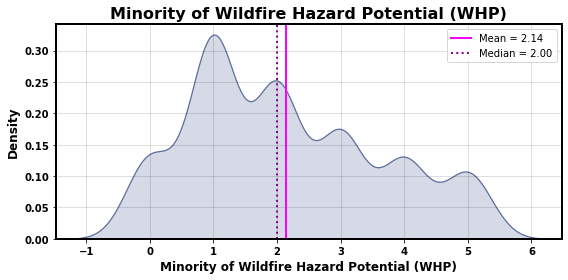

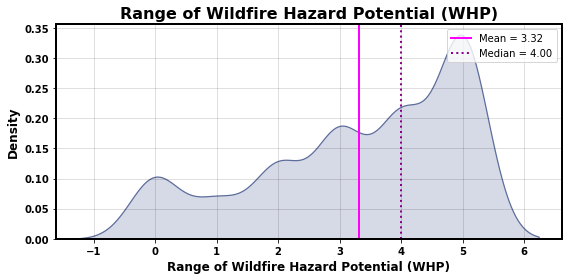

In [25]:
# Utilize function to display a KDE plot for all WHP-related variables
whp_cols = ['whp_min','whp_max','whp_mean','whp_median',
            'whp_majority','whp_minority','whp_range']

whp_titles = ['Min of Wildfire Hazard Potential (WHP)',
              'Max of Wildfire Hazard Potential (WHP)',
              'Mean of Wildfire Hazard Potential (WHP)',
              'Median of Wildfire Hazard Potential (WHP)',
              'Majority of Wildfire Hazard Potential (WHP)',
              'Minority of Wildfire Hazard Potential (WHP)',
              'Range of Wildfire Hazard Potential (WHP)']

for col in range(len(whp_cols)):
  kde_plot(eda_df, whp_cols[col],
          tit_lab=whp_titles[col], 
          fs=(8,4),
          x_lab=whp_titles[col])

####**WHP-related columns to keep**

- We will only keep the following metrics for WHP-derived metrics for next step of analysis
  - `whp_median`
  - `whp_mean`
  - `whp_minority`
- These metrics have unique types of data distribution and will be likely to address different aspects in the data better than the rest

In [26]:
# create a list to store columns names to keep
cols_keep = ['whp_median','whp_mean','whp_minority']
cols_keep

['whp_median', 'whp_mean', 'whp_minority']

###**2.2 Risk to Potential Structures (RPS) related variables**

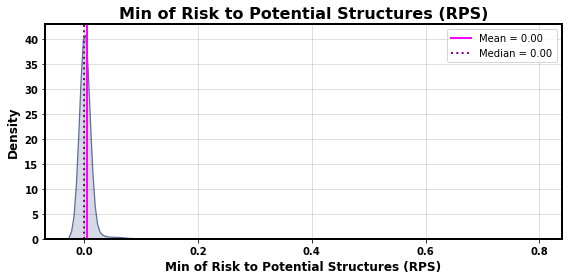

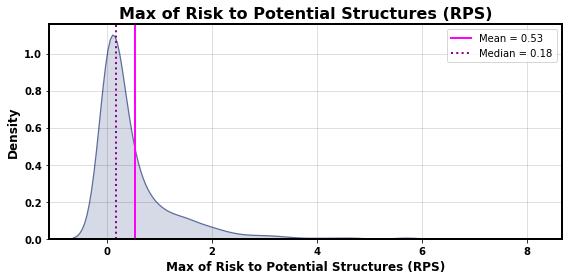

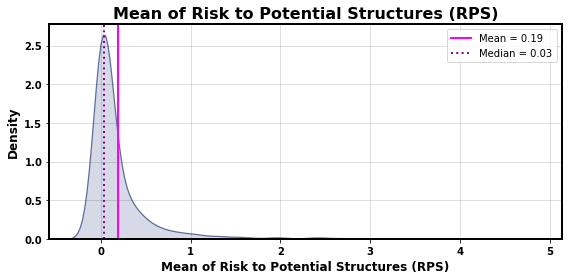

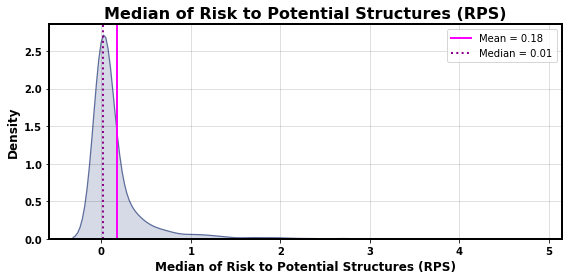

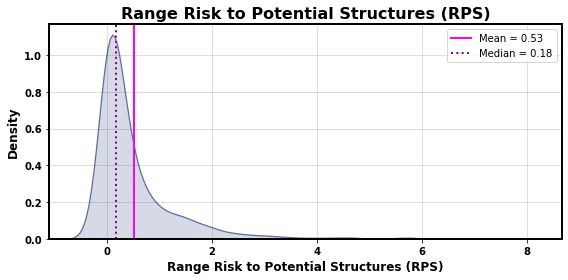

In [27]:
# Utilize function to display a KDE plot for all RPS-related variables
rps_cols = ['rps_min','rps_max','rps_mean','rps_median',
            'rps_range']

rps_titles = ['Min of Risk to Potential Structures (RPS)',
              'Max of Risk to Potential Structures (RPS)',
              'Mean of Risk to Potential Structures (RPS)',
              'Median of Risk to Potential Structures (RPS)',
              'Range Risk to Potential Structures (RPS)']

for col in range(len(rps_cols)):
  kde_plot(eda_df, rps_cols[col],
          tit_lab=rps_titles[col], 
          fs=(8,4),
          x_lab=rps_titles[col])

- Create box plots to identify outliers in RPS-derived variables

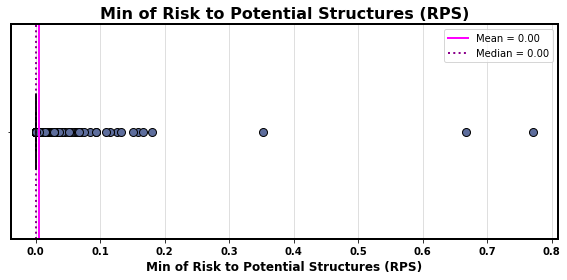

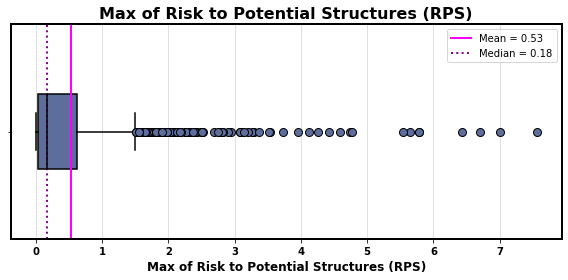

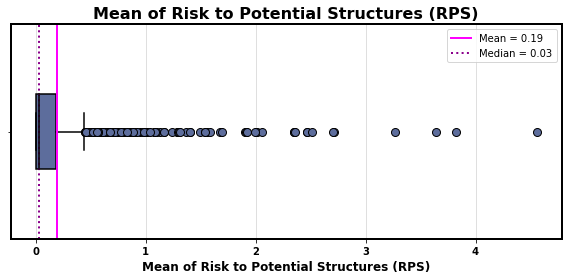

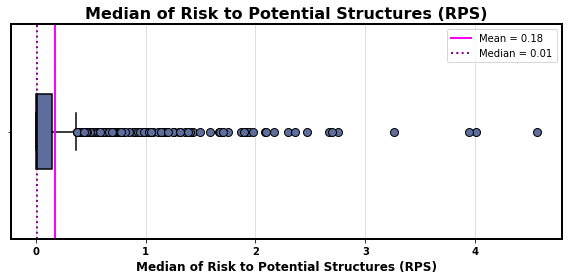

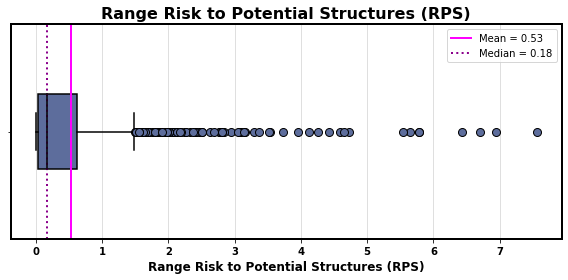

In [28]:
# create box plots to identify outliers in RPS-derived variables
# box_plot(eda_df, 'z_score',
#              tit_lab='Mann-Kendall Test', 
#              fs=(8,4),
#          x_lab = 'Coefficient')

for col in range(len(rps_cols)):
  box_plot(eda_df, rps_cols[col],
              tit_lab=rps_titles[col], 
              fs=(8,4),
          x_lab = rps_titles[col])

- We decide to keep the high-value outliers
  - These data points indicates a high risk of risk to potential structures
  - They are data of interest and should be included in the modeling to answer our research question

####**RPS-related columns to keep**

- We will only keep the following metrics for WHP-derived metrics for next step of analysis
  - `rps_min`
  - `rps_max`
  - `rps_median`
- These metrics have unique types of data distribution and will be likely to address different aspects in the data better than the rest

In [29]:
# add to the list for column names to keep
cols_keep = cols_keep + ['rps_min','rps_max','rps_median']
cols_keep

['whp_median', 'whp_mean', 'whp_minority', 'rps_min', 'rps_max', 'rps_median']

###**2.3 House affordability**

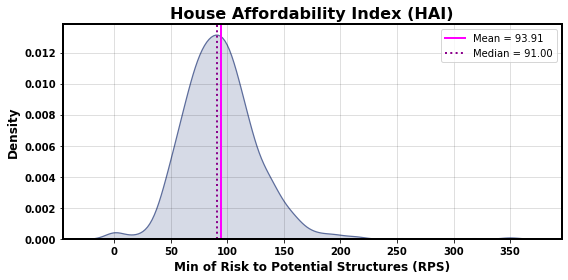

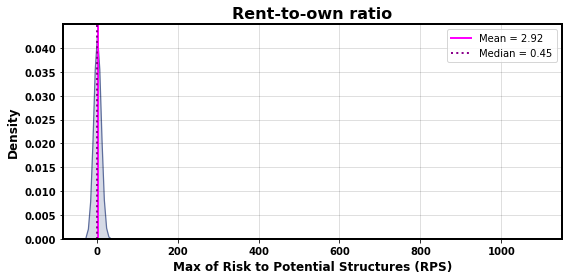

In [30]:
# Utilize function to display a KDE plot for all RPS-related variables
hai_cols = ['hai', 'rent_own_ratio']

hai_titles = ['House Affordability Index (HAI)','Rent-to-own ratio']

for col in range(len(hai_cols)):
  kde_plot(eda_df, hai_cols[col],
          tit_lab=hai_titles[col], 
          fs=(8,4),
          x_lab=rps_titles[col])

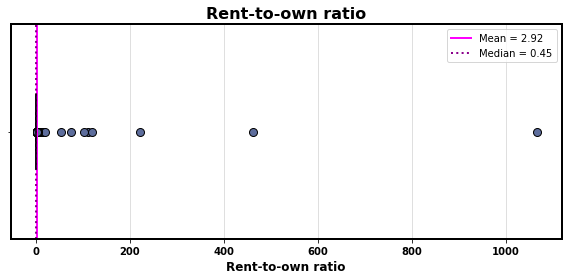

In [31]:
# further check the outliers in rent_own_ratio column
box_plot(eda_df, 'rent_own_ratio',
              tit_lab='Rent-to-own ratio', 
              fs=(8,4),
          x_lab = 'Rent-to-own ratio')

**Findings**
- There are a number of rows with `hai = 0`, indicating HAI is not available for this census tract
  - According to the [data description](https://www.arcgis.com/home/item.html?id=a1263c2dcdf2464bbb7906821038eb2f), this occurs in a predominantly rental market
  - **We will remove these rows for next steps of analysis**
  
- Rent-to-own ratio contains several high-value outliers
  - `rent_own_ratio = 200` indicates that residents who rent homes are two-times higher than residents who own homes, meaning a low house affordability
  - We will **remove `rent_own_ratio > 200`** to get rid of extremely unaffordable census tracts, that are very likely to locate next to the urban area with very low wildfire risk
  - These rows may also have an `hai = 0`

In [32]:
# check the type of WUI and the level of wildfire risk for rows with 
# hai == 0
eda_df[(eda_df.hai == 0)]

,geoid,county,trend,wui_class,owner_num,renter_num,hai,income_mortage_ratio,diversity_index,med_house_income,...,whp_mean,whp_majority,whp_minority,whp_median,rps_mean,rps_median,rps_min,rps_max,rps_range,rent_own_ratio
127,6001422800,Alameda County,increasing,High_Dens_Interface,15,1654,0,0.0,72.0,17630,...,0.000000,0,0,0,0.002025,0.000867,0.000006,0.009605,0.009599,110.267
207,6073009400,San Diego County,decreasing,High_Dens_Interface,1,463,0,0.0,70.0,56956,...,2.447183,3,1,3,0.557245,0.432579,0.000000,1.370856,1.370856,463.000
215,6115040902,Yuba County,decreasing,Med_Dens_Interface,4,409,0,0.0,65.4,47893,...,2.659922,3,5,3,0.146765,0.104520,0.000000,0.631372,0.631372,102.250
298,6059052518,Orange County,increasing,High_Dens_Interface,4,4262,0,0.0,66.5,101867,...,0.150000,0,1,0,0.005891,0.001697,0.000000,0.076385,0.076385,1065.500
640,6037190402,Los Angeles County,increasing,High_Dens_Interface,6,1331,0,0.0,70.0,33154,...,0.000000,0,0,0,0.000539,0.000433,0.000110,0.001437,0.001327,221.833
729,6075060100,San Francisco County,increasing,Med_Dens_Interface,17,1258,0,0.0,47.5,200001,...,0.719512,0,1,0,0.001996,0.000000,0.000000,0.043970,0.043970,74.000
829,6095252801,Solano County,decreasing,Med_Dens_Interface,7,845,0,0.0,70.8,60539,...,0.285714,0,2,0,0.006826,0.004772,0.000000,0.036028,0.036028,120.714
997,6085511608,Santa Clara County,increasing,Low_Dens_Interface,2,107,0,0.0,75.1,39092,...,1.162162,0,4,1,0.020484,0.003120,0.000000,0.088328,0.088328,53.500
1088,6055200900,Napa County,decreasing,Low_Dens_Intermix,2,20,0,0.0,67.4,28016,...,1.367647,2,1,2,0.018336,0.014415,0.000000,0.087797,0.087797,10.000


In [33]:
# check the type of WUI and the level of wildfire risk for rows with 
# rent_own_ratio > 200
eda_df[(eda_df.rent_own_ratio > 200)]

,geoid,county,trend,wui_class,owner_num,renter_num,hai,income_mortage_ratio,diversity_index,med_house_income,...,whp_mean,whp_majority,whp_minority,whp_median,rps_mean,rps_median,rps_min,rps_max,rps_range,rent_own_ratio
207,6073009400,San Diego County,decreasing,High_Dens_Interface,1,463,0,0.0,70.0,56956,...,2.447183,3,1,3,0.557245,0.432579,0.00000,1.370856,1.370856,463.000
298,6059052518,Orange County,increasing,High_Dens_Interface,4,4262,0,0.0,66.5,101867,...,0.150000,0,1,0,0.005891,0.001697,0.00000,0.076385,0.076385,1065.500
640,6037190402,Los Angeles County,increasing,High_Dens_Interface,6,1331,0,0.0,70.0,33154,...,0.000000,0,0,0,0.000539,0.000433,0.00011,0.001437,0.001327,221.833


In [34]:
## remove rows with hai = 0
eda_df = eda_df[(eda_df.hai > 0) & (eda_df.hai < 200)]

print(f'eda_df now has {eda_df[(eda_df.hai == 0)].shape[0]} rows with hai = 0')

eda_df now has 0 rows with hai = 0


####**House affordability columns to keep**

In [35]:
# add to col_keeps
cols_keep = cols_keep + ['hai','rent_own_ratio']
cols_keep

['whp_median',
 'whp_mean',
 'whp_minority',
 'rps_min',
 'rps_max',
 'rps_median',
 'hai',
 'rent_own_ratio']

###**2.4 Income-related metrics**

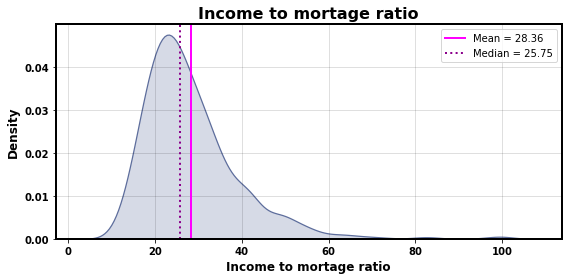

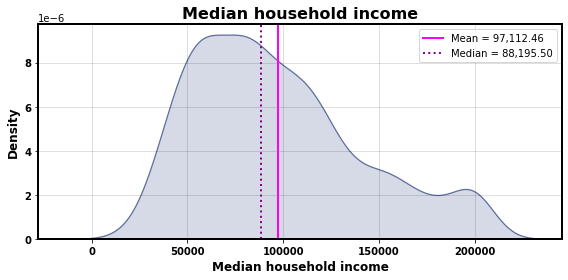

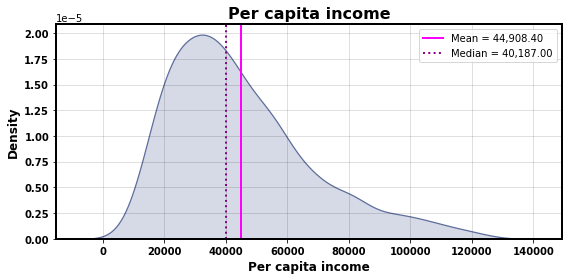

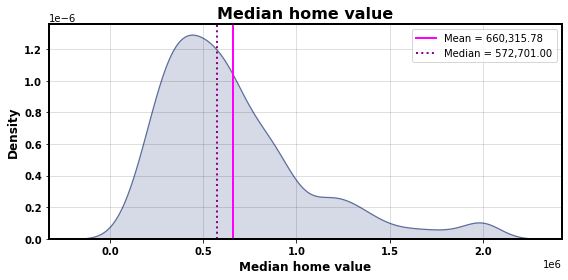

In [36]:
# Utilize function to display a KDE plot for all RPS-related variables
income_cols = ['income_mortage_ratio','med_house_income','per_capita_income',
               'med_home_value']

income_titles = ['Income to mortage ratio','Median household income',
                 'Per capita income','Median home value']

for col in range(len(income_cols)):
  kde_plot(eda_df, income_cols[col],
          tit_lab=income_titles[col], 
          fs=(8,4),
          x_lab=income_titles[col])

- Keep all the income-related metrics
  - They do not have overalapped (too similar) data distribution and address a unique aspect in the research question

####**Income-related columns to keep**

In [37]:
# add to the list for column names to keep
cols_keep = cols_keep + income_cols
cols_keep

['whp_median',
 'whp_mean',
 'whp_minority',
 'rps_min',
 'rps_max',
 'rps_median',
 'hai',
 'rent_own_ratio',
 'income_mortage_ratio',
 'med_house_income',
 'per_capita_income',
 'med_home_value']

###**2.5 Demographics columns**

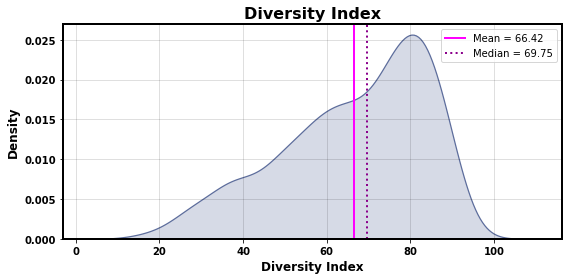

In [38]:
# Utilize function to display a KDE plot for selected variables
dem_cols = ['diversity_index']

dem_titles = ['Diversity Index']

for col in range(len(dem_cols)):
  kde_plot(eda_df, dem_cols[col],
          tit_lab=dem_titles[col], 
          fs=(8,4),
          x_lab=dem_titles[col])

####**Demographic columns to keep**

In [39]:
# add to the list for column names to keep
cols_keep = cols_keep + dem_cols
cols_keep

['whp_median',
 'whp_mean',
 'whp_minority',
 'rps_min',
 'rps_max',
 'rps_median',
 'hai',
 'rent_own_ratio',
 'income_mortage_ratio',
 'med_house_income',
 'per_capita_income',
 'med_home_value',
 'diversity_index']

###**2.6 Categorical columns**

In [40]:
# get index for selected cols
data_types = eda_df.dtypes
cat_cols = data_types[data_types=='object'].index
cat_cols

Index(['county', 'trend', 'wui_class'], dtype='object')

- We will not keep any categorical columns as they are either not relevant to the modeling or have duplicated meaning with existing numeric variables
  - WUI type is based on the level of wilderness and population density
  - This aspect has been addressed by WHP-related variables already

###**2.7 Correlation between variables chosen for analysis**

In [41]:
## obtain a new eda_df as final dataframe for analysis
eda_df_upd = eda_df[cols_keep + [target_val]]
eda_df_upd.head()

,whp_median,whp_mean,whp_minority,rps_min,rps_max,rps_median,hai,rent_own_ratio,income_mortage_ratio,med_house_income,per_capita_income,med_home_value,diversity_index,percent_pop_change
0,4,3.660041,2,0.000000,0.793326,0.374090,141,0.303,16.6,70529,30478,279852,47.7,18.268690
1,0,1.000000,2,0.000000,0.071251,0.010501,124,0.155,18.6,105220,41801,468636,69.5,123.471883
3,0,0.000000,0,0.000000,0.598311,0.000004,147,0.215,16.1,91415,37164,352245,70.9,12.823834
4,0,0.000000,0,0.000009,0.007597,0.000320,47,3.571,50.7,69564,40702,843487,76.8,9.795102
5,2,2.295082,1,0.000000,0.299861,0.115787,87,0.062,27.5,200001,100935,1314579,37.2,7.673975


In [42]:
# get more information of the eda_df_upd
eda_df_upd.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1042 entries, 0 to 1282
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   whp_median            1042 non-null   int64  
 1   whp_mean              1042 non-null   float64
 2   whp_minority          1042 non-null   int64  
 3   rps_min               1042 non-null   float64
 4   rps_max               1042 non-null   float64
 5   rps_median            1042 non-null   float64
 6   hai                   1042 non-null   int64  
 7   rent_own_ratio        1042 non-null   float64
 8   income_mortage_ratio  1042 non-null   float64
 9   med_house_income      1042 non-null   int64  
 10  per_capita_income     1042 non-null   int64  
 11  med_home_value        1042 non-null   int64  
 12  diversity_index       1042 non-null   float64
 13  percent_pop_change    1042 non-null   float64
dtypes: float64(8), int64(6)
memory usage: 154.4 KB


####**Heatmap between variables**

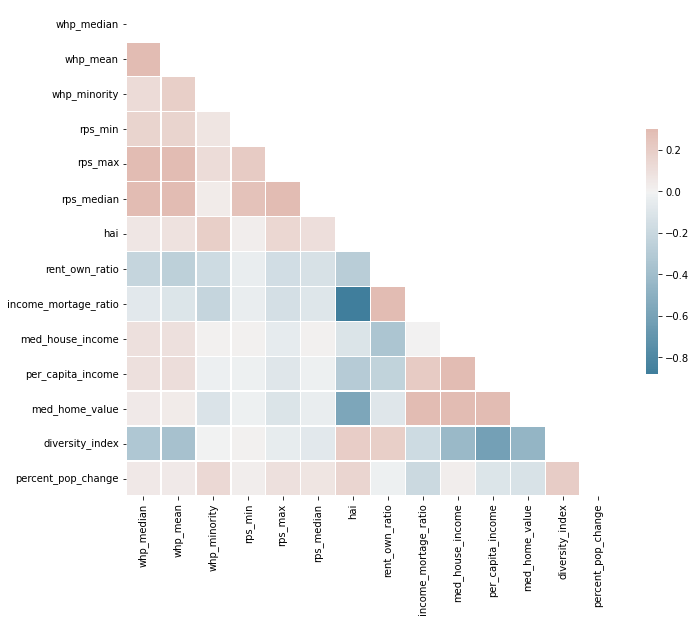

In [43]:
# create a correlation heatmap to select less correlated numeric variables 
# to investigate
# create a heatmap using seaborn
# Compute the correlation matrix
data_types = eda_df_upd.dtypes
num_cols = data_types[data_types != 'object'].index
corr = eda_df_upd[num_cols].corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# decimal_2_fmt = StrMethodFormatter('{x:.2}')
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5,
            cbar_kws={"shrink": .5});

####**Findings of heatmap**

- The following variables have a relatively high correlation with the target variable
  - positive
    - `whp_minority`
    - `hai`
    - `diversity_index`
  - negative
    - `income_mortage_ratio`
    - `med_home_value`
- These findings indicate
  - House affordability is driving the population increase inside WUI during the past decade in California
  - People are residing more in areas where homes are more affordable inside WUI
  - Home values and income-mortage ratio are two variables negatively related to the hosue affordability, which also contribute to the relationship between house affordability and population increase
  - Wildfire risk is NOT a driving factor for this pattern
    - People care more about home affordability and can tolerate some risk of being exposed to a high-risk zone of wildfire

####**Relationship between `percent_population_change` and `hai`**

In [70]:
# Create a function to create a Scatter Plot
def scatter_plot(df, x, y, file_name='',
                 tit_lab='', x_lab='', y_lab=''):
    
    # PLot
    fig, ax = plt.subplots(figsize=(8,4), facecolor='w');
    # sns.scatterplot(x=df[x], y=df[y], cmap=col_pal);
    sns.regplot(x=df[x], y=df[y], lowess=True, line_kws={"color": "C1"});
    
    # Regression Line
    m, b, *_ = stats.linregress(df[x], df[y])
    # Labels
    plt.title(tit_lab, fontsize = 16, weight='bold')
    plt.xlabel(x_lab, fontsize = 12, weight='bold')
    plt.ylabel(y_lab, fontsize = 12, weight='bold')
    # Ticks
    plt.xticks(fontsize = 10, weight='bold')
    plt.yticks(fontsize = 10, weight='bold')
    # Face 
    ax.set_facecolor('w')
    # Spines
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(2)
    # Display
    # plt.legend(bbox_to_anchor=(1.23, 1))
    plt.tight_layout()
    plt.show;

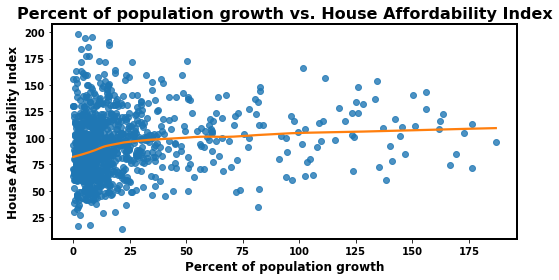

In [71]:
scatter_plot(eda_df_upd, x=target_val,y='hai',
             tit_lab = 'Percent of population growth vs. House Affordability Index',
             x_lab = 'Percent of population growth',
             y_lab = 'House Affordability Index')

**Findings**

- House affordability index is a metric based on the financial burden over a hosuehold's income and the home price in the census tract
- The correlation between percent of population increase and house affordability index has some correlation but such relationship is relatively week.
  - Census tracts inside WUI with very limited population increase may have a large range of census HAI
  - **The low values (bottom 25%) in the percent of population growth do not show a strong relationship with the HAI**
  - **This means a further filtering may be necessary so that the analysis is focused on the census tracts with the greatest population increase**

####**Relationship between `percent_population_change` and `diversity index`**

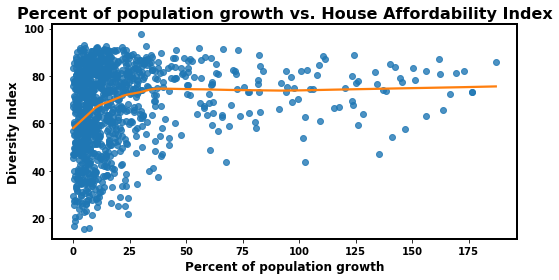

In [72]:
scatter_plot(eda_df_upd, x=target_val,y='diversity_index',
            tit_lab = 'Percent of population growth vs. House Affordability Index',
             x_lab = 'Percent of population growth',
             y_lab = 'Diversity Index')

**Findings**

- Indication of diversity index
  - A higher diversity index means the population of the census tract is more diverse ethnically
- The correlation between percent of population increase and (demographic) diversity index has a stronger correlation compared to the relationship with HAI
- Still, census tracts inside WUI with very limited population increase may have a large range of census diversity index
- **Such positive correlation is stronger for census tracts that are among the top 25% of percent of population increase values**

####**Relationship between `income_mortage_ratio` and `hai`**

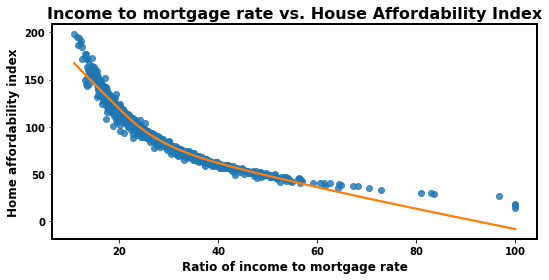

In [75]:
scatter_plot(eda_df_upd, x='income_mortage_ratio',y='hai',
             tit_lab = 'Income to mortgage rate vs. House Affordability Index',
             x_lab = 'Ratio of income to mortgage rate',
             y_lab = 'Home affordability index')

####**Findings**

- These two metrics are highly (negatively) correlated
  - HAI is derived partly based on income to mortage ratio
- An higher income to mortage rate indicates the family needs to spend a large proportion of income to pay off their mortage, meaning homes are less affordable
- **This figure indicates a high multilinearity between these two metrics**
  - PCA and other feature engineering will help to reduce the multilinearity

##**3. Random forest model**

- First try a random forest model to fit to the target variable in the current `eda_df_upd` datafrane
- Tune the hyperparameters of the random forest model using GridSearchCV

###**3.1 Prepare train and test data**

In [48]:
eda_df_upd.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1042 entries, 0 to 1282
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   whp_median            1042 non-null   int64  
 1   whp_mean              1042 non-null   float64
 2   whp_minority          1042 non-null   int64  
 3   rps_min               1042 non-null   float64
 4   rps_max               1042 non-null   float64
 5   rps_median            1042 non-null   float64
 6   hai                   1042 non-null   int64  
 7   rent_own_ratio        1042 non-null   float64
 8   income_mortage_ratio  1042 non-null   float64
 9   med_house_income      1042 non-null   int64  
 10  per_capita_income     1042 non-null   int64  
 11  med_home_value        1042 non-null   int64  
 12  diversity_index       1042 non-null   float64
 13  percent_pop_change    1042 non-null   float64
dtypes: float64(8), int64(6)
memory usage: 154.4 KB


In [49]:
# Arrange Data into Features Matrix and Target Vector
y = eda_df_upd['percent_pop_change']
X = eda_df_upd.drop(columns = 'percent_pop_change')

# Split the data for validation
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

###**3.2 An initial random forest model**

In [50]:
# # a function to fit a model and get predictions of a given model type
def model_fitter(model_pipeline, X_train, y_train, X_test):
  # # assemble a pipeline for preprocessor and the model
  # model_pipe

  # fit model
  model_pipeline.fit(X_train, y_train)

  # get predictions
  train_preds = model_pipeline.predict(X_train)
  test_preds = model_pipeline.predict(X_test)

  # print a sample of predictions
  print('***First 5 train data predictions***\n')
  print(train_preds[:5])
  print('`\n***First 5 test data predictions***\n')
  print(test_preds[:5])

  # return predictions
  result = [train_preds, test_preds]
  return(result)

In [51]:
## Evaluate 
def evaluate_regression(model,X_train,X_test,y_train,y_test):
    """Uses model.score to display the R^2 values for training and test splits"""
    print(f"Training R^2: {model.score(X_train,y_train):.3f}")
    print(f"Test R^2: {model.score(X_test,y_test):.3f}")

In [52]:
# train and fit the default RM model
rf = RandomForestRegressor(random_state = 42)

In [53]:
# assemble a preprocessor
num_sel = make_column_selector(dtype_include='number')

preprocessor = make_column_transformer((StandardScaler(), num_sel),
                                               remainder='drop')
preprocessor

ColumnTransformer(transformers=[('standardscaler', StandardScaler(),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7f7b236da040>)])

In [54]:
# fit the random forest model
rf_pipeline = make_pipeline(preprocessor, rf)
result_rf = model_fitter(rf_pipeline, X_train, y_train, X_test)
train_preds_rf = result_rf[0]
test_preds_rf = result_rf[1]

***First 5 train data predictions***

[11.50176092  9.06792017 53.4286684  11.74292335 41.38324693]
`
***First 5 test data predictions***

[17.90002319 23.96456688 10.96076589 26.7498845  24.56042639]


In [55]:
# evaluate model performance
evaluate_regression(rf_pipeline,X_train, X_test,y_train,y_test)

Training R^2: 0.868
Test R^2: 0.104


####**Findings**

- The default model showed a very poor model performance over testing data

###**3.3 Tuning the hyperparameters of RF**

In [ ]:
rf_pipeline.get_params()

{'memory': None,
 'steps': [('columntransformer',
   ColumnTransformer(transformers=[('standardscaler', StandardScaler(),
                                    <sklearn.compose._column_transformer.make_column_selector object at 0x7f0483b0f3a0>)])),
  ('randomforestregressor', RandomForestRegressor(random_state=42))],
 'verbose': False,
 'columntransformer': ColumnTransformer(transformers=[('standardscaler', StandardScaler(),
                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f0483b0f3a0>)]),
 'randomforestregressor': RandomForestRegressor(random_state=42),
 'columntransformer__n_jobs': None,
 'columntransformer__remainder': 'drop',
 'columntransformer__sparse_threshold': 0.3,
 'columntransformer__transformer_weights': None,
 'columntransformer__transformers': [('standardscaler',
   StandardScaler(),
   <sklearn.compose._column_transformer.make_column_selector at 0x7f0483b0f3a0>)],
 'columntransformer__verbose': False,
 'columntransfor

In [ ]:
## Make lists of depths to try
param_grid = {'randomforestregressor__max_depth': np.arange(5,100,5),
              'randomforestregressor__n_estimators': [50, 100, 150, 200, 250]}

# param_grid = {'randomforestregressor__n_estimators': [50, 100, 150, 200, 250]}
param_grid

{'randomforestregressor__max_depth': array([ 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85,
        90, 95]),
 'randomforestregressor__n_estimators': [50, 100, 150, 200, 250]}

In [ ]:
# add GridSearchCV to model pipeline
rf_pipe_gs = GridSearchCV(rf_pipeline, param_grid)
 
rf_pipe_gs.fit(X_train, y_train)
print('Best RF Parameters:')
print(rf_pipe_gs.best_params_)
best_pipe = rf_pipe_gs.best_estimator_
print(f'Accuracy of best RF model is: {best_pipe.score(X_test, y_test)}')

Best RF Parameters:
{'randomforestregressor__max_depth': 5, 'randomforestregressor__n_estimators': 200}
Accuracy of best RF model is: 0.10225777659368929


####**Findings**
- Due to the limitations in the data used for modeling, tuning hyperparameters do not help improve model performance
- We need to reconsider whether we need to further manipulate our data. Here are some options:
  - Focus on census tracts that showed a strong enough correlation between population increase and determining features rather than including the majority of low-increase values

##**4. PCA for model improvement**

In [56]:
# create a scaler
scaler = StandardScaler()
# Create a PCA object that will retain 95% of the variance when transforming
pca = PCA(n_components = .95)

In [57]:
# Combine the scaler and the PCA in a pipeline.
scaler_pca = make_pipeline(scaler, pca)

# Transform the training data and check shape of new features after applying PCA
X_train_pca = scaler_pca.fit_transform(X_train)
print(f'The total number of columns have decreased from {X_train.shape[1]} to {X_train_pca.shape[1]}.')

The total number of columns have decreased from 13 to 8.


In [59]:
# Create and fit an RF model WITH PCA.
rf_pca = make_pipeline(scaler, pca, RandomForestRegressor(max_depth = 5,
                                                          n_estimators = 200,
                                                          random_state = 42))
rf_pca.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('pca', PCA(n_components=0.95)),
                ('randomforestregressor',
                 RandomForestRegressor(max_depth=5, n_estimators=200,
                                       random_state=42))])

In [60]:
# apply RF with PCA and record time
%%time
preds_pca = rf_pca.predict(X_test)

CPU times: user 26 ms, sys: 0 ns, total: 26 ms
Wall time: 27.9 ms


In [61]:
# evaluate model performance
evaluate_regression(rf_pca,X_train, X_test,y_train,y_test)

Training R^2: 0.485
Test R^2: 0.122


####**Findings**

- PCA as a feature engineering method slightly improved the model performance, but it does not fundamentally change the overall poor performance of the current model
- Further filtering of data is needed based on the current findings
- This will also help further distill the research questions and preliminary conclusions, for example:
  - For census tracts that experienced the most drastic population increase, home affordability is a crucial driver
  - For census tracts that experienced a statistically significant, but not the strongest population increase (e.g. bottom 25% of percent population increase) 